In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
from pytrends.request import TrendReq
from datetime import date
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import mplcyberpunk

In [ ]:
#Operar Sinais -> Mesma direção em momentos normais e momentos de pico
#Operar momentum -> Opera em direção ao Mtum1m nos momentos de pico de pesquisa do ticker. Ou ta bom ou deu merda.
#Operar vol -> quando há pico de pesquisas, necessariamente, a ação se mexe mais que o normal?
#calcular mediana do retorno em periodos de pico contra mediana em semanas normais.

In [ ]:
'''

Só que operar sinais tem um problema no caso do ticker
As pessoas só compra algo ou porque deu merda ou porque ta hypado

presidente petrobras x PETR4.SA
privatizao eletrobras x ELET3.SA


'''

In [3]:
def pesquisa_x_sinal(ticker, palavra, tempo_comeco, periodos, maiores = False):
    
    hoje = date.today()
    comeco= hoje - relativedelta(years=tempo_comeco)

    dados_acao = yf.download(f"{ticker}", start=comeco, end=hoje)['Adj Close']
    dados_acao = dados_acao.resample('w').last()
    dados_acao = dados_acao.iloc[:-2]
    mtum1 = dados_acao.pct_change(periods = 4)
    

    req = TrendReq(hl='en-US', tz=360)
    req.build_payload(palavra, cat = 0, timeframe = f'{comeco} {hoje}', geo = "BR", gprop = "")
    dados_procura = req.interest_over_time()
    dados_procura = dados_procura[f'{palavra[0]}']
    dados_procura = dados_procura.replace(0, 0.0001)
    
    cor = pd.merge(dados_procura,dados_acao, right_index=True, left_index=True).pct_change().dropna()
    cor.columns = [f'{palavra[0]}' , f'{ticker}']
    cor[f'{palavra[0]}'] = cor[f'{palavra[0]}'].shift(periods=periodos)
    cor = cor.dropna()
    
    if maiores == True:
        
        cor = cor.sort_values(f"{palavra[0]}", ascending = False)
        cor = cor.head(5)
        
    
    pct_cor = cor.apply(lambda x : 1 if x[f'{ticker}'] > 0 and x[f'{palavra[0]}'] > 0 or x[f'{ticker}'] < 0 and x[f'{palavra[0]}'] < 0 else 0, axis=1)
    pct_cor = pct_cor.sum()/len(pct_cor)
    
    cor[f"{palavra[0]}"] = cor[f"{palavra[0]}"].map(lambda x: str(round(x * 100, 2)) + "%")
    cor[f'{ticker}'] = cor[f'{ticker}'].map(lambda x: str(round(x * 100, 2)) + "%")
    
    ticker = ticker.replace(".SA", "")
    
    cor.columns = [f'Pesquisa {palavra[0]}' , f'Retorno {ticker}']
    
    print(cor)
    
    print("A quantidade de semanas com sinal igual é: ",round(pct_cor*100,2),"%")

    
    
    



In [3]:
hoje = date.today()
comeco= hoje - relativedelta(years=1)

req = TrendReq(hl='en-US', tz=360)
req.build_payload('teste', cat = 0, timeframe = f'{comeco} {hoje}', geo = "BR", gprop = "")

$$
S_{t + 1} = 
\left\{  
  \begin{array}{ c l }
    1, & \quad \textrm{if } \frac{P_{t - 1}}{P{t}} - 1 > 50\% \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right.$$

In [16]:
def pesquisa_x_mtum(ticker, palavra, tempo_comeco, periodos, maiores = False):
    
    hoje = date.today()
    comeco= hoje - relativedelta(months=25)
    comeco_trend = hoje - relativedelta(months=24)

    dados_acao = yf.download(f"{ticker}", start=comeco, end=hoje)['Adj Close']
    dados_acao = dados_acao.resample('w').last()
    mtum1 = dados_acao.pct_change()
    mtum1 = mtum1.iloc[3:]
    mtum1 = mtum1.dropna()
    mtum1.name = "mtum1m"
    dados_acao = dados_acao.iloc[4:-2]

    req = TrendReq(hl='en-US', tz=360)
    req.build_payload(palavra, cat = 0, timeframe = f'{comeco_trend} {hoje}', geo = "BR", gprop = "")
    dados_procura = req.interest_over_time()
    dados_procura = dados_procura[f'{palavra[0]}']
    dados_procura = dados_procura.replace(0, 0.0001)
    
    cor = pd.merge(dados_procura,dados_acao, right_index=True, left_index=True).pct_change()
    cor = pd.merge(cor, mtum1, right_index=True, left_index=True).dropna()
    
    cor.columns = [f'{palavra[0]}' , f'{ticker}', "mtum1m"]
    cor[[f'{palavra[0]}', "mtum1m"]] = cor[[f'{palavra[0]}', "mtum1m"]].shift(periods=periodos)
    cor = cor.dropna()
    
    if maiores == True:
        
        cor = cor.sort_values(f"{palavra[0]}", ascending = False)
        cor = cor[cor[f'{palavra[0]}'] > 0.5]
        
    
    pct_cor = cor.apply(lambda x : 1 if x[f'{ticker}'] > 0 and x['mtum1m'] > 0 or 
                        x[f'{ticker}'] < 0 and x['mtum1m'] < 0 else 0, axis=1)
    
    pct_cor = pct_cor.sum()/len(pct_cor)
    retorno_min = cor[f'{ticker}'].min()
    retorno_max = cor[f'{ticker}'].max()
    retorno_med = cor[f'{ticker}'].mean()
    
    cor[f"{palavra[0]}"] = cor[f"{palavra[0]}"].map(lambda x: str(round(x * 100, 2)) + "%")
    cor[f'{ticker}'] = cor[f'{ticker}'].map(lambda x: str(round(x * 100, 2)) + "%")
    cor[f'mtum1m'] = cor[f'mtum1m'].map(lambda x: str(round(x * 100, 2)) + "%")
    
    cor.columns = [f"Pesquisa {palavra[0]}", "Rent semana seguinte", "Rent semana hype"]
    
    cor = cor[[f"Pesquisa {palavra[0]}", "Rent semana hype", "Rent semana seguinte"]]
    
    display(cor)
    
    print("A quantidade de semanas com mesmo sinal da semana do hype é: ",round(pct_cor*100,2),"%")

In [8]:
def pesquisa_x_vol(ticker, palavra, tempo_comeco, periodos, maiores = False):
    
    hoje = date.today()
    comeco= hoje - relativedelta(years=tempo_comeco)

    dados_acao = yf.download(f"{ticker}", start=comeco, end=hoje)['Adj Close']
    dados_acao = dados_acao.resample('w').last()
    dados_acao = dados_acao.iloc[:-2]


    req = TrendReq(hl='en-US', tz=360)
    req.build_payload(palavra, cat = 0, timeframe = f'{comeco} {hoje}', geo = "BR", gprop = "")
    dados_procura = req.interest_over_time()
    dados_procura = dados_procura[f'{palavra[0]}']
    dados_procura = dados_procura.replace(0, 0.0001)
    
    cor = pd.merge(dados_procura,dados_acao, right_index=True, left_index=True).pct_change().dropna()
    cor.columns = [f'{palavra[0]}' , f'{ticker}']
    cor[f'{palavra[0]}'] = cor[f'{palavra[0]}'].shift(periods=periodos)
    cor = cor.dropna()
        
    cor = cor.sort_values(f"{palavra[0]}", ascending = False)
    retornos_palavra_no_hype = cor.head(5)
    
    cor['classe'] = ['normal'] * len(cor)
    
    cor.loc[cor.index.isin(retornos_palavra_no_hype.index), "classe"] = "retorno hype"
    
    colors = {'normal':'tab:blue', 'retorno hype':'tab:pink'}
    
    plt.style.use("cyberpunk")
    
    media_amostra = cor[f"{ticker}"].mean()
    
    desvio_padrao = cor[f"{ticker}"].std()
    
    fig, ax = plt.subplots()
    
    ax.scatter(cor[f"{palavra[0]}"], cor[f"{ticker}"], c=cor['classe'].map(colors))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(False)
    plt.axhline(media_amostra, **{"color":"white"})
    plt.axhline(media_amostra + desvio_padrao, **{"color":"white", "linestyle": "--"})
    plt.axhline(media_amostra + desvio_padrao * 2, **{"color":"white", "linestyle": "--"})
    plt.axhline(media_amostra - desvio_padrao, **{"color":"white", "linestyle": "--"})
    plt.axhline(media_amostra - desvio_padrao * 2, **{"color":"white", "linestyle": "--"})
    plt.title(f"Retornos {palavra[0]} x Pesquisa {palavra[0]}")
    
    print(cor)
    
    desvio_padrao = cor[f"{ticker}"].std()
    
    media_absoluta_amostra = cor[f"{ticker}"].abs().mean()
    
    media_asboluta_5 = retornos_palavra_no_hype[f"{ticker}"].abs().mean()
    
    print(f"A variação média absoluta da amostra é {round(media_absoluta_amostra * 100, 2)}%")
    print(f"A variação média absoluta das semanas hypadas é {round(media_asboluta_5 * 100, 2)}%")

    


In [10]:
pesquisa_x_sinal(ticker = "PETR4.SA", 
                 palavra = ["presidente petrobras"], 
                 tempo_comeco = 2, #2 anos
                 periodos = 1,
                maiores = True)

NameError: name 'pesquisa_x_sinal' is not defined

In [18]:
pesquisa_x_mtum(ticker = "ITUB3.SA", 
                 palavra = ["ITUB3"], 
                 tempo_comeco = 2, #2 anos
                 periodos = 1,
                maiores = True)

#testar p petrobras, mglu e cogn3

#parece que não funciona muito e, no caso de COGN3, na semana seguinte a gente devia operar uma reversão de tendencia.
#ou seja, contra o momentum.
# Já em MGLU operar momentum teria dado acerto nos 3 maiores movimento do google trends.



[*********************100%***********************]  1 of 1 completed


,Pesquisa ITUB3,Rent semana hype,Rent semana seguinte
2022-08-14,105.71%,5.07%,7.09%
2023-11-12,84.62%,1.97%,5.75%
2023-07-23,82.76%,-3.16%,2.49%
2023-01-29,80.95%,-1.28%,-4.74%
2023-03-12,79.31%,-4.31%,-0.53%
2022-12-18,69.23%,-4.73%,-2.33%
2023-08-13,64.1%,-1.47%,-2.59%
2022-03-06,57.14%,-3.09%,-3.55%
2023-01-08,56.76%,0.14%,0.4%


A quantidade de semanas com mesmo sinal da semana do hype é:  88.89 %


In [ ]:
'''
aqui a thread pode ter um tom de "bom, parece que ate agora a gente não achou muita coisa"
Nem no caso de termos correlacionados com o negócio nem em pesquisa por ticker no google. 
Alguns a tendencia ajudaria, outros não. 
Em petrobras, na semana mais pesquisa em 2 anos, você tomaria um -18% na semana
seguinte achando que o momento era positivo.


Ok, mas e sobre a volatilidade? (algo assim, elabora melhor)
''

[*********************100%***********************]  1 of 1 completed
               MGLU3  MGLU3.SA        classe
2021-11-14  1.218750 -0.103698  retorno hype
2021-07-18  1.166667  0.090328  retorno hype
2021-02-28  0.692308 -0.030473  retorno hype
2022-03-20  0.620690  0.022847  retorno hype
2020-11-15  0.587302 -0.081595  retorno hype
...              ...       ...           ...
2021-04-25 -0.319149 -0.008668        normal
2021-07-25 -0.338462 -0.054393        normal
2022-03-27 -0.372340  0.123711        normal
2021-02-21 -0.380952 -0.037437        normal
2022-03-06 -0.424242  0.046589        normal

[101 rows x 3 columns]
A variação média absoluta da amostra é 6.84%
A variação média absoluta das semanas hypadas é 6.58%


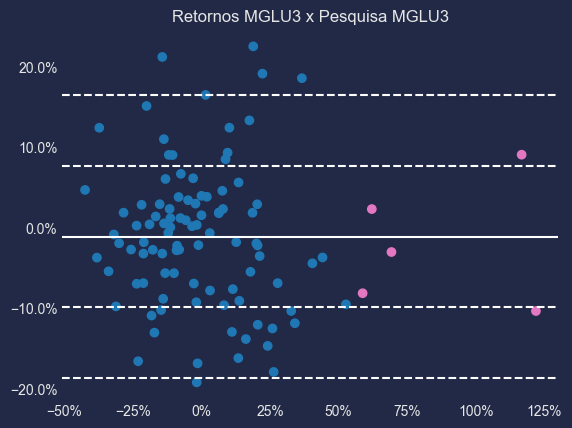

In [200]:
pesquisa_x_vol(ticker = "MGLU3.SA", 
                 palavra = ["MGLU3"], 
                 tempo_comeco = 2, #2 anos
                 periodos = 1
                )




#quantos desvios padrões o pior retorno dos 5 está?